### Transformation 1 - Log Returns 

- Due to challenges presented in the previous Jupyter, such as non-stationarity identified through the ADF and KPSS tests, but also the presence of multiplicative seasonal variations.  
- The present Jupyter will be composed by the Log Returns pipeline in order to handle non-stationarity and to reduce the impact of  seasonal variations.

In [2]:
# Importing libraries for the project.
import pandas as pd
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler, PowerTransformer, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from pandas.plotting import lag_plot

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the same dataset from the same source. 
# Defines ticker symbol for S&P 500 index.
ticker_symbol = "^GSPC"

# Fetch historical data.
sp500_data = yf.download(ticker_symbol, start="2013-12-31", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Selecting only the column to be used, the closing prices. 
df = sp500_data['Close']

In [5]:
df.head() # Displays first five rows. 

Date
2013-12-31    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
Name: Close, dtype: float64

### Data preparation steps (Same as the first Jupyter)

The pre-processing stage is the same in all notebooks to ensure consistency and fairness.  

In [7]:
df = df.asfreq('b') # Setting the frequency to business days. 

In [8]:
# Forward fill NaN values in the 'Close' column.
df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame with forward filled values.
display(df)

Date
2013-12-31    1848.359985
2014-01-01    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
                 ...     
2023-12-25    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Freq: B, Name: Close, Length: 2609, dtype: float64

### Stationarity Check 

In [10]:
# Stationarity check ADF and KPSS test. 
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.274939693479533
p-value: 0.9289793936532919
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 7.951934
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


- Like in the previous notebook, The p-value and statistic values for both test indicates that the series is not stationarity.

## Transformation - Log Returns

Through test results (ADF and KPSS), non-stationarity was identified and a transformation is required to change it. 
The first approach to be applied is the Log Returns: 
- The technique will try to remove the trend and stabilize the variance in the series and  
- Volatility present, especially during 2020 (pandemic) and log functions could be a good attempt for big changes.
- Percentage Changes: It can be easier for models to forecast, rather than using the prices or index. 

In [12]:
# Applying log return in S&P 500 index.
log_df = np.log(df / df.shift(1))

# Because of the log return, the first row of the log will be NaN Value, thus dropping the first row to continue with the analysis.
log_df = log_df.dropna()

In [13]:
# Stationarity check ADF and KPSS test. 
# ADF Test
result = adfuller(log_df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(log_df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.777094199081597
p-value: 2.2753379840436895e-27
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 0.026462
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


After applying the log retuns and accordingly with the: 
- ADF test: the p-value is way below 0.05 (2.27e-27), also the statistic value is below all critical values. 
- KPSS test: with the p-value of 0.1 and  the statistic value below all critical values. 

Thus, the results shows that the transformation was sucessful, achieving stationarity. 

In [15]:
# Shows the statistical features of the S&P 500 index before and after the transformation. 
print(df.describe())
print(log_df.describe())

count    2609.000000
mean     3005.472863
std       901.733128
min      1741.890015
25%      2124.199951
50%      2793.899902
75%      3902.620117
max      4796.560059
Name: Close, dtype: float64
count    2608.000000
mean        0.000364
std         0.011013
min        -0.127652
25%        -0.003545
50%         0.000302
75%         0.005250
max         0.089683
Name: Close, dtype: float64


By observing the statistical features:
- The number of entries reduced by 1, which is expected by the transformation. 
- The mean of the log returns is 0.0003, thus the majority of the values are clustered around zero. 

In [17]:
# Transforming to dataframe for visualization.
# Creates a copy and converts the Series to a DataFrame.
df1 = log_df.to_frame()

# Creates a year column for grouping.
df1['Year'] = df1.index.year

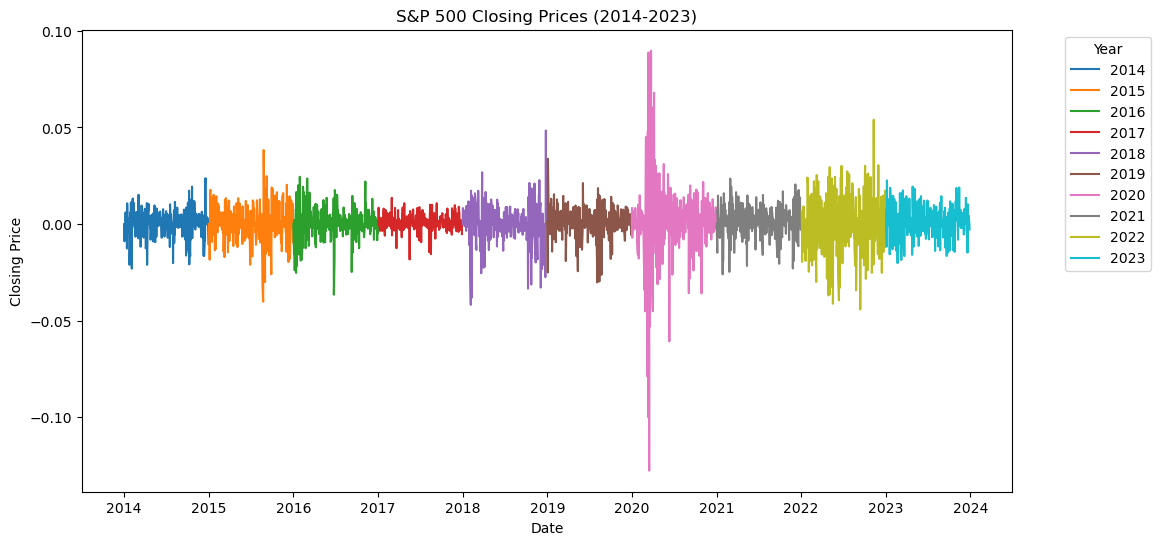

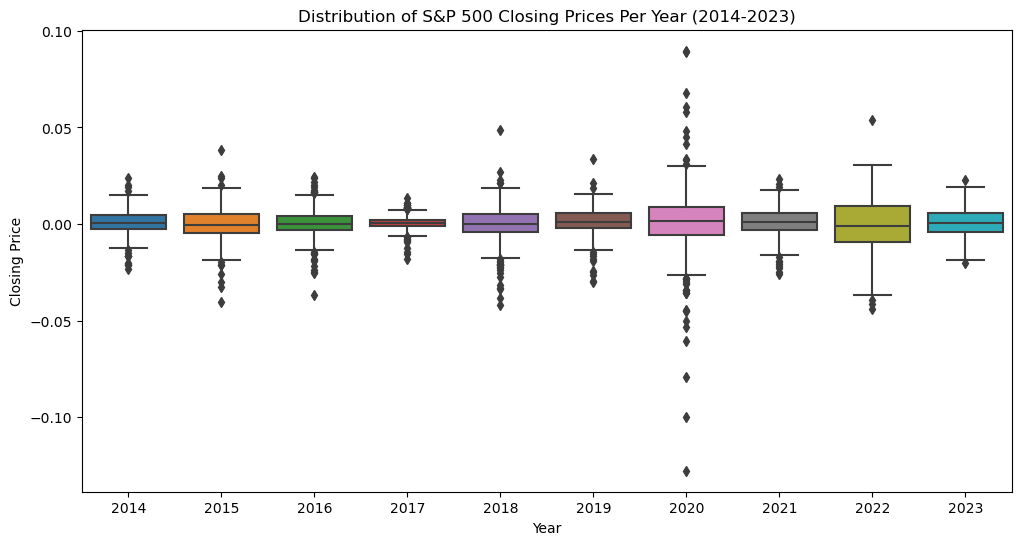

In [18]:
# Line Plot per Year
plt.figure(figsize=(12, 6)) # Sets fig size.
# Sets  the lineplot where the colors are based on the yeard, following the tab10 palette, providing clarity to the observer. 
sns.lineplot(data=df1, x=df1.index, y='Close', hue='Year', palette='tab10') 
plt.title('S&P 500 Closing Prices (2014-2023)') # Sets title.
plt.xlabel('Date') # Add label.
plt.ylabel('Closing Price') # Add label.
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Adds legend (years) and configures it. 
plt.show() # Display the fig. 

# Box Plot per Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=df1)
plt.title('Distribution of S&P 500 Closing Prices Per Year (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

Text(0.5, 1.0, 'Boxplot of S&P500 index overtime (10 years)')

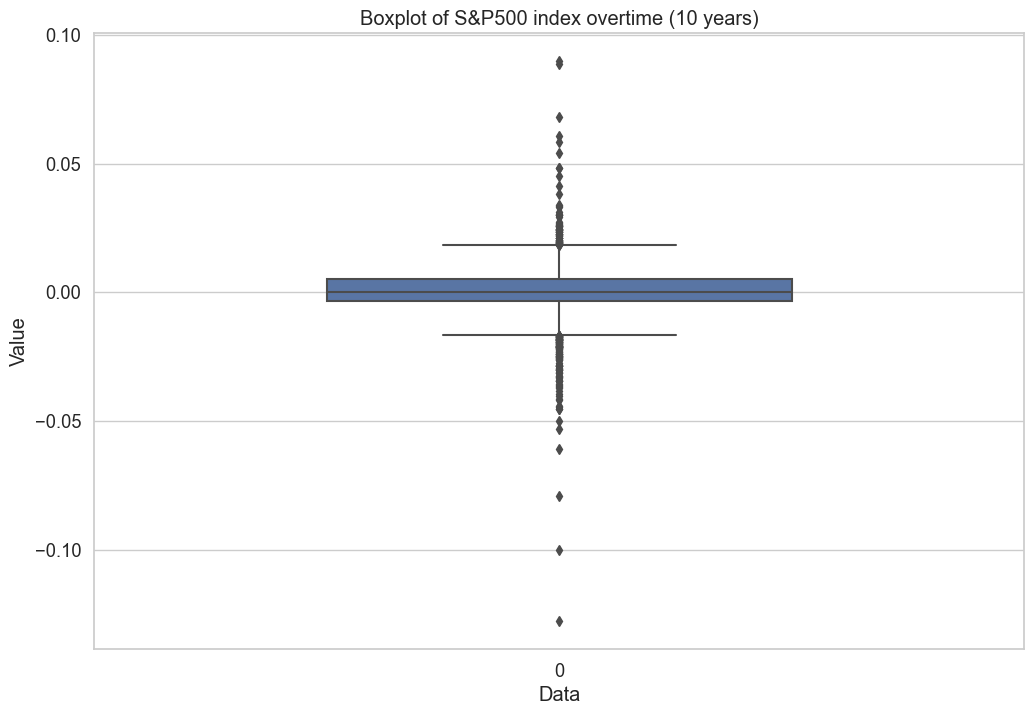

In [19]:
plt.figure(figsize=(12, 8)) # Set up the plot and adjust the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Add a whitegrid in the backgound for clear visualization.
# Creates the boxplot with all the columns.
ax = sns.boxplot(data=log_df, width=0.5) # Sets the width to 0.5
 # Add labels and ha argument used to align the labels to the designated boxplot.
ax.set_xlabel('Data') # Adds x-axis label.
ax.set_ylabel('Value') # Adds y-axis label.
ax.set_title('Boxplot of S&P500 index overtime (10 years)') # Sets title to tle boxplot.

- The lineplots shows the log returns overtime where its values remained between the range of 0.05 and -0.05, but after the COVID pandemic the market became more volatile with extreme values. 
- The boxplot of the all period indicates the presence of outliers. But, looking at the boxplots per year it shows that every year outliers are present, especially at the year of 2020 (high volatility and extreme values). 

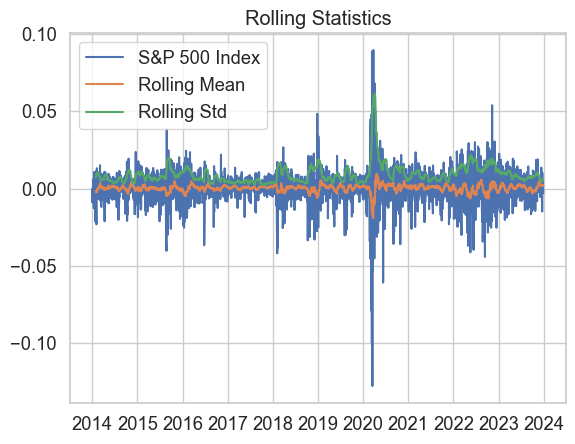

In [21]:
# Stationarity check (one month of trading)
# Assuming 'time_series_data' is your time series data
rolling_mean = log_df.rolling(window=21).mean()
rolling_std = log_df.rolling(window=21).std()

plt.plot(log_df, label='S&P 500 Index')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Statistics')
plt.show()

- The rolling statistics also shows the high volalitily in 2020. And with the addition of other plots and statistical tests it indicates that the log return technique made the S&P500 index stationarity, normalizing and stabilizing the data. 

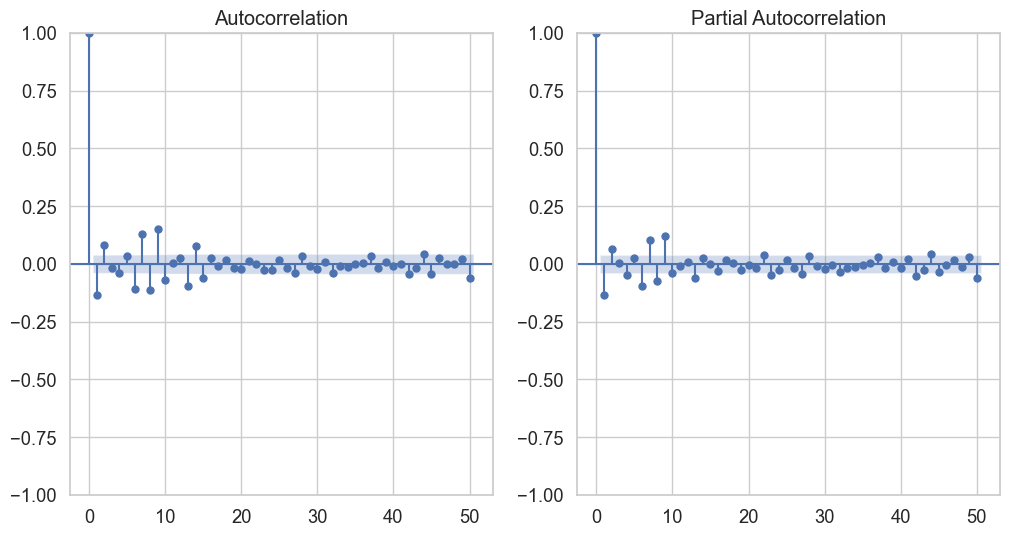

In [23]:
# ACF and PACF of log returns
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(log_df, ax=plt.gca(), lags=50) # sets the acf plot. 
plt.subplot(122)
plot_pacf(log_df, ax=plt.gca(), lags=50) # sets the pacf plot. 
plt.show() # shows the plots

The correlation plots shows that: 
- ACF: points a high correlation between the past value, but after the first lag the correlation disapper overtime.
- PACF: also shows a huge spike at the first lag and shows almost no correlation after the fist lag. 

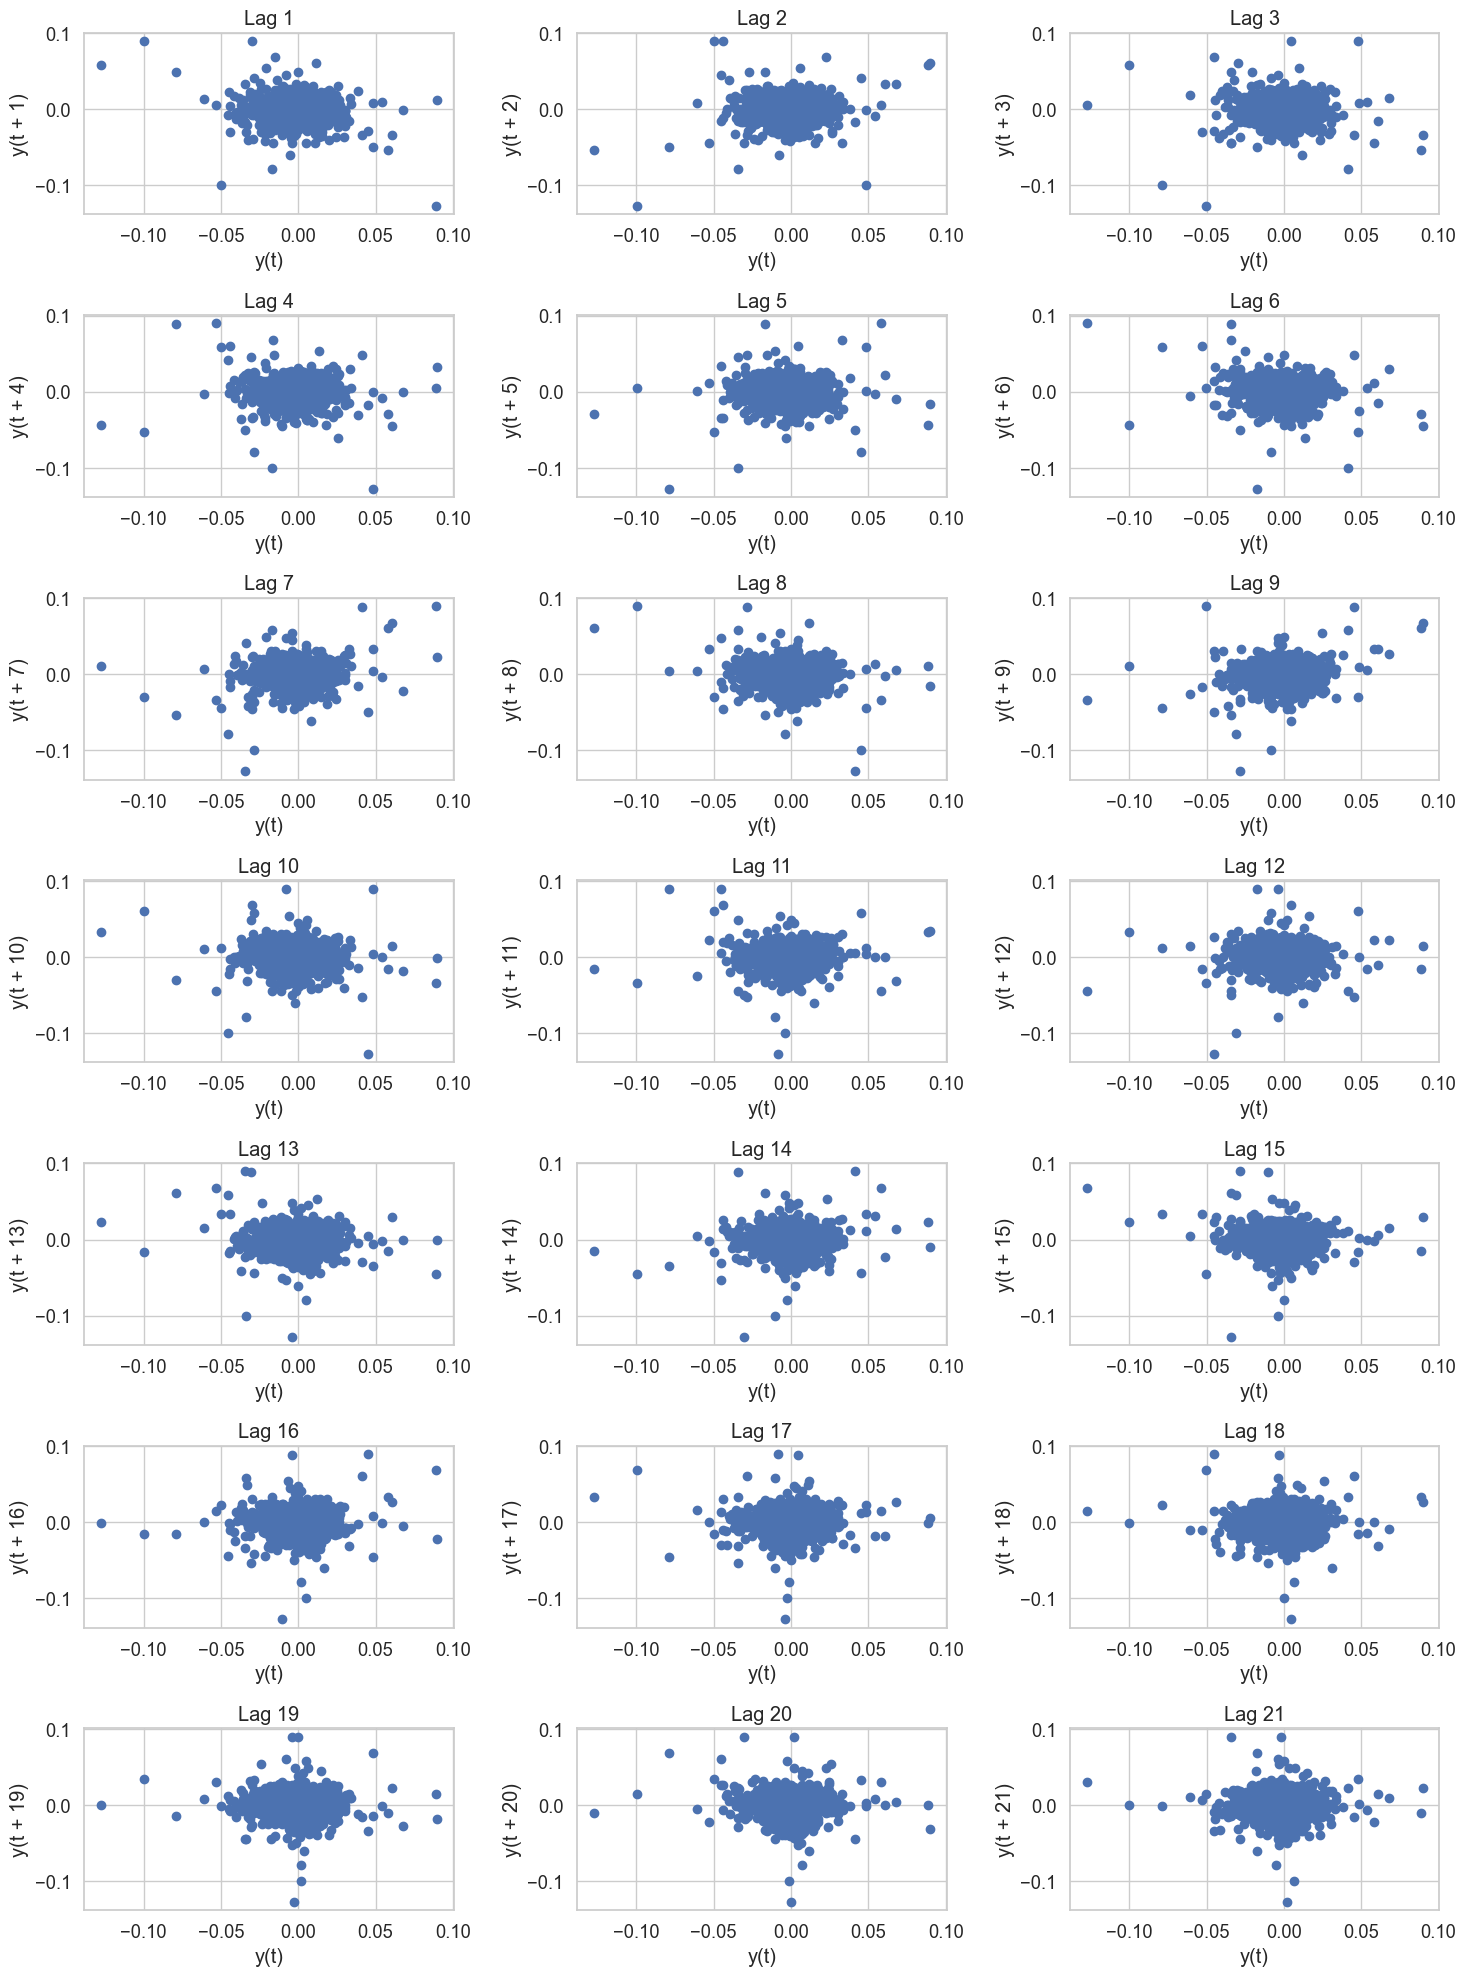

In [25]:
# Define the number of lags
number_of_lags = 21

# Create subplots with 3 columns
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a lag plot for each lag
for i in range(1, number_of_lags + 1):
    lag_plot(log_df, lag=i, ax=axes[i-1])
    axes[i-1].set_title(f'Lag {i}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

<b>Within the scope of the project, Neural Networks would be the only forecasting technology that requires scaling (improve perfomance and stability), thus additional data preparation will be perfomed at this stage.</b>

# Why Scaling is Important for Neural Networks: (DIFFERENT WORDS).
- **Gradient Descent Efficiency**: Neural networks use gradient descent for optimization. If the data is not scaled, large feature values can cause slow or unstable convergence.
- **Consistent Learning**: Features on vastly different scales can disproportionately affect the learning process, making it difficult for the network to learn efficiently.
- **Improved Performance**: Scaled data helps in reducing the risk of the model getting stuck in local minima and allows for faster training.

Thus, between the techniques available, three approaches were selected for the trade-offs:
    
- **Min and Max scaler**: Scaling the data between zero and one, it will attempt to normalize the series. 

- **Robust scaler**: Approach that is robust against outliers, which are present in the data (volatility). 

- **PowerTransformer (Yeo-Johnson)**: In contrast to the Box-Cox, the Yeo-Johnson can handle negative values and the approch will attempt to normalize the data.  

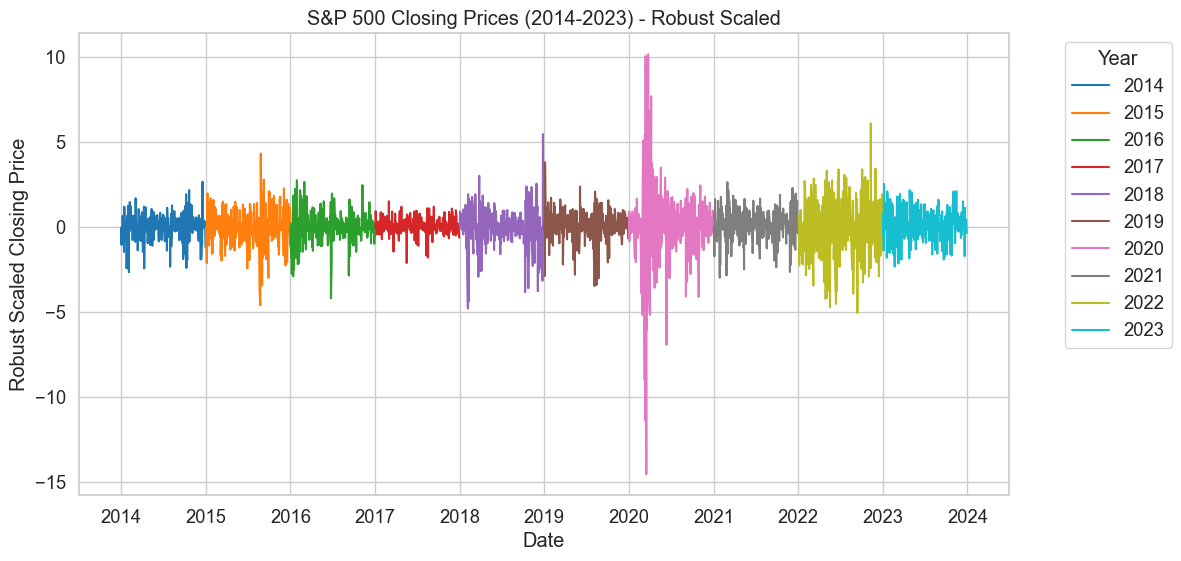

In [27]:
# Initializes the Robust Scaler.
robust_scaler = RobustScaler()

# Fit and transforms the log Returns (Close) column.
df1['Close_Robust_Scaled'] = robust_scaler.fit_transform(df1[['Close']])

# Plotting the scaled data.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x=df1.index, y='Close_Robust_Scaled', hue='Year', palette='tab10') # Sets line, color, "splits" by year.
plt.title('S&P 500 Closing Prices (2014-2023) - Robust Scaled') # Sets the title.
plt.xlabel('Date') # Date Label.
plt.ylabel('Robust Scaled Closing Price') # Type of Scaling label.
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Sets legend and config to better visualization. 
plt.show() # shows the figure.

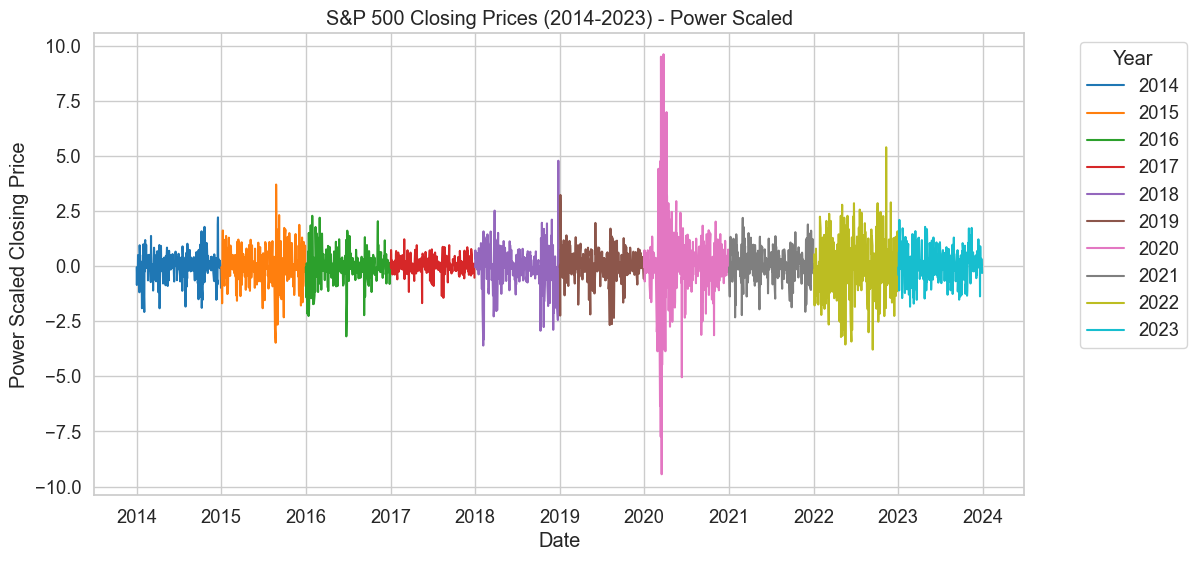

In [28]:
# Initialize the Power Scaler with yeo-johnson method.
power_scaler = PowerTransformer(method='yeo-johnson')

# Fit and transforms the log Returns (Close) column.
df1['Close_Power_Scaled'] = power_scaler.fit_transform(df1[['Close']])

# Plotting the scaled data
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x=df1.index, y='Close_Power_Scaled', hue='Year', palette='tab10') # Sets line, color, "splits" by year.
plt.title('S&P 500 Closing Prices (2014-2023) - Power Scaled') # Sets the title.
plt.xlabel('Date') # Date Label.
plt.ylabel('Power Scaled Closing Price') # Type of Scaling label.
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Sets legend and config to better visualization. 
plt.show() # shows the figure.

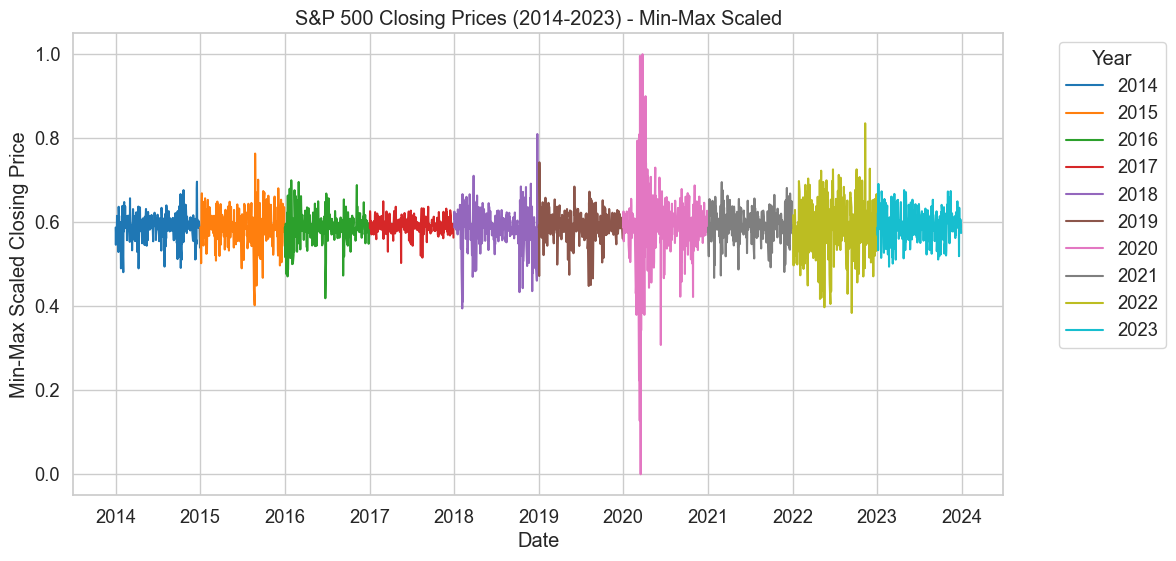

In [29]:
# Initializes the Min-Max Scaler.
min_max_scaler = MinMaxScaler()

# Fit and transforms the log Returns (Close) column.
df1['Close_MinMax_Scaled'] = min_max_scaler.fit_transform(df1[['Close']])

# Plotting the scaled data.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x=df1.index, y='Close_MinMax_Scaled', hue='Year', palette='tab10') # Sets line, color, "splits" by year. 
plt.title('S&P 500 Closing Prices (2014-2023) - Min-Max Scaled') # Sets the title. 
plt.xlabel('Date') # Date Label.
plt.ylabel('Min-Max Scaled Closing Price') # Type of Scaling label.
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Sets legend and config to better visualization. 
plt.show() # shows the figure.

In [30]:
df1.head() # First five rows of the frame with scaled values 

,Close,Year,Close_Robust_Scaled,Close_Power_Scaled,Close_MinMax_Scaled
Date,,,,,
2014-01-01,0.000000,2014,-0.034348,-0.053312,0.587351
2014-01-02,-0.008901,2014,-1.046392,-0.853915,0.546394
2014-01-03,-0.000333,2014,-0.072211,-0.083738,0.585819
2014-01-06,-0.002515,2014,-0.320282,-0.282166,0.575779
2014-01-07,0.006063,2014,0.655022,0.507234,0.615250


- The impact of the applied scaling techniques (RobustScaler, PowerTransformer, and MinMaxScaler) only changes the scale of the data without changing its underlying structure or temporal dependencies. 

- Double check, if the scaling approaches had any impact regarding stationarity. 

In [32]:
# Function to perform ADF test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('\n')

# Function to perform KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series.dropna(), regression='c')
    labels = ['KPSS Statistic', 'p-value', '#Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('\n')

# Perform ADF and KPSS tests
adf_test(df1['Close_Robust_Scaled'], 'Close Robust Scaled')
kpss_test(df1['Close_Robust_Scaled'], 'Close Robust Scaled')

adf_test(df1['Close_Power_Scaled'], 'Close_Power_Scaled')
kpss_test(df1['Close_Power_Scaled'], 'Close_Power_Scaled')

adf_test(df1['Close_MinMax_Scaled'], 'Close MinMax Scaled')
kpss_test(df1['Close_MinMax_Scaled'], 'Close MinMax Scaled')

Augmented Dickey-Fuller Test: Close Robust Scaled
ADF Statistic                 -1.477709e+01
p-value                        2.275338e-27
#Lags Used                     1.200000e+01
Number of Observations Used    2.595000e+03
Critical Value (1%)           -3.432872e+00
Critical Value (5%)           -2.862654e+00
Critical Value (10%)          -2.567363e+00


KPSS Test: Close Robust Scaled
KPSS Statistic           0.026462
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000


Augmented Dickey-Fuller Test: Close_Power_Scaled
ADF Statistic                 -1.531470e+01
p-value                        4.140890e-28
#Lags Used                     1.200000e+01
Number of Observations Used    2.595000e+03
Critical Value (1%)           -3.432872e+00
Critical Value (5%)           -2.862654e+00
Critical Value (10%)          -2.567363e+00


KPSS Test:

- Both tests, ADF and KPSS, shows that the series still remains stationary after applying the scaling techniques. 

**Note**: The dataset with all the transformations will be saved to apply forecating machine learning models in a different Jupyter. Organization and lighter notebook are the main reasons for this step.

In [34]:
# Path to save to the Desktop
#df1.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_log.csv', index=True)